## Аппроксимация Q-функции

В этой тетрадке мы будем использовать библиотеку tensorflow для обучения нейронной сети, хотя можно использовать и любую другую библиотеку. 

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Будем тестировать наши модели на классической задаче с перевернутым маятником:

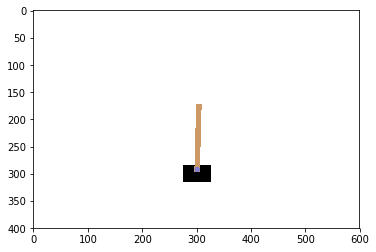

In [2]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [3]:
env.close()

# Глубокое Q-обучение: построение сети

Так как описание состояния в задаче с маятником представляет собой не "сырые" признаки, а уже предобработанные (координаты, углы), нам не нужна для начала сложная архитектура, начнем с такой:

<img src="qlearningscheme.png" caption="Архитектура сети">
Для начала попробуйте использовать только полносвязные слои (__L.Dense__) и линейные активационные функции. Сигмоиды и другие функции не будут работать с ненормализованными входными данными.

In [4]:
import tensorflow as tf
import keras
import keras.layers as L
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

Using TensorFlow backend.


In [5]:
network = keras.models.Sequential()
network.add(L.InputLayer(state_dim))
# строим сеть!
#~~~~~~~~ Ваш код здесь ~~~~~~~~~~~
raise NotImplementedError
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



NotImplementedError: 

In [6]:
import random
def get_action(state, epsilon=0):
    """
    сэмплируем (eps greedy) действие  
    """
    q_values = network.predict(state[None])[0]
    
    ### Ваш код здесь - нужно выбрать действия eps-жадно
    # action = 
    #~~~~~~~~ Ваш код здесь ~~~~~~~~~~~    
    raise NotImplementedError    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    return action


In [7]:
assert network.output_shape == (None, n_actions), \
    "убедитесь, что стратегия переводит \
    s -> [Q(s,a0), ..., Q(s, a_last)]"
assert network.layers[-1].activation == \
       keras.activations.linear, \
    "убедитесь, что вы предсказываете q без нелинейности"
# проверяем исследование
s = env.reset()
assert np.shape(get_action(s)) == (), \
    "убедитесь, что возвращаете одно действие"
for eps in [0., 0.1, 0.5, 1.0]:
    na = n_actions
    st = np.bincount([get_action(s, epsilon=eps) \
                      for i in range(10000)],
                     minlength=na)
    ba = st.argmax()
    assert abs(
        st[ba] - 10000 * (1 - eps + eps / na)) < 200
    for oa in range(na):
        if oa != ba:
            assert abs(st[oa] - 10000 * (eps / na)) < 200
    print('e=%.1f tests passed' % eps)

### Q-обучение через градиентный спуск

Теперь будем приближать Q-функцию агента, минимизируя TD функцию потерь:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2. $$

Основная тонкость состоит в использовании  $Q_{-}(s',a')$. Эта та же самая функция, что и $Q_{\theta}$, которая является выходом нейронной сети, но при обучении сети, мы не пропускаем через эти слои градиенты. Для этого используется функция `tf.stop_gradient`.

In [8]:
# Создаем placeholders для <s, a, r, s'>, 
# а также индикатор окончания эпизода (is_done = True)
states_ph = tf.placeholder('float32', 
                           shape=(None,) + state_dim)
actions_ph = tf.placeholder('int32', shape=[None])
rewards_ph = tf.placeholder('float32', shape=[None])
next_states_ph = tf.placeholder('float32', 
                           shape=(None,) + state_dim)
is_done_ph = tf.placeholder('bool', shape=[None])

In [9]:
# получаем q для всех действий, в текущем состоянии
predicted_qvalues = network(states_ph)

# получаем q-values для выбранного действия
predicted_qvalues_for_actions =\
tf.reduce_sum(
predicted_qvalues * tf.one_hot(actions_ph, n_actions),
    axis=1)

In [10]:
gamma = 0.99

# применяем сеть для получения q-value для next_states_ph
# predicted_next_qvalues =
#~~~~~~~~ Ваш код здесь ~~~~~~~~~~~
raise NotImplementedError
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# вычисляем V*(next_states) 
# по предсказанным следующим q-values
# next_state_values =
#~~~~~~~~ Ваш код здесь ~~~~~~~~~~~
raise NotImplementedError
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Вычисляем target q-values для функции потерь 
# target_qvalues_for_actions = 
#~~~~~~~~ Ваш код здесь ~~~~~~~~~~~
raise NotImplementedError
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# для последнего действия используем 
# упрощенную формулу Q(s,a) = r(s,a) 
target_qvalues_for_actions =\
tf.where(is_done_ph, rewards_ph, 
         target_qvalues_for_actions)

$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2. $$


In [11]:
### среднеквадратичная функция потерь stop_gradient
# loss = 
#~~~~~~~~ Ваш код здесь ~~~~~~~~~~~
raise NotImplementedError
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# применяем AdamOptimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [12]:
assert tf.gradients(loss, \
    [predicted_qvalues_for_actions])[0] is not None, \
"убедитесь, что обновление выполняется\
только для выбранного действия"
assert tf.gradients(loss, \
    [predicted_next_qvalues])[0] is None, \
"убедитесь, что вы не распространяете градиент Q_(s',a')"
assert predicted_next_qvalues.shape.ndims == 2, \
"убедитесь, что вы предсказываете q для всех действий,\
следующего состояния"
assert next_state_values.shape.ndims == 1, \
"убедитесь, что вы вычислили V(s') как максимум\
только по оси действий, а не по всем осям"
assert target_qvalues_for_actions.shape.ndims == 1, \
"что-то не так с целевыми q-значениями,\
они должны быть вектором"

### Playing the game

In [13]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """генерация сессии"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph: [a], 
                rewards_ph: [r], next_states_ph: [next_s], 
                is_done_ph: [done]
            })

        total_reward += r
        s = next_s
        if done: break
            
    return total_reward

In [14]:
epsilon = 0.8

In [ ]:
for i in range(100):
    session_rewards = [generate_session(epsilon=epsilon, 
                        train=True) for _ in range(500)]
    print("epoch #{}\tmean r = {:.3f}\tepsilon = {:.3f}"
          .format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.95
    epsilon = max(0.1, epsilon)
    assert epsilon >= 1e-4, \
    "убедитесь, что epsilon не становится < 0"
    if np.mean(session_rewards) > 300:
        print ("Принято!")
        break


### Интерпретация результатов

\begin{itemize}
\item mean reward -- среднее вознаграждение за эпизод. В случае корректной реализации, этот показатель будет низким первые 5 эпох и только затем будет возрастать и сойдется на 20-30 эпох в зависииости от архитектуры сети.
\item Если сеть не достигает нужных результатов к концу цикла, попробуйте увеличить число нейронов в скрытом слое или поменяйте $\epsilon$.
\item epsilon -- обеспечивает стремление агента исследовать среду. Можно искусственно изменять малые значения $\epsilon$ при низких результатах на 0.1 - 0.5.
\end{itemize}